In this project, you will begin working with COBRA (COnstraint-Based Reconstruction and Analysis) methods using the Python library [cobrapy](https://opencobra.github.io/cobrapy/). Originally implemented in MATLAB as the COBRA Toolbox, cobrapy is an object-oriented programming framework for the reconstruction and analysis of constraint-based metabolic models. Although still not as comprehensive as the COBRA Toolbox when it comes to modeling capabilities and implemented algorithms, it provides ample functionality to cover our needs for this course. Before starting with this project, I strongly encourage you to take a look at the [documentation](https://cobrapy.readthedocs.io/en/latest) and [API reference](https://cobrapy.readthedocs.io/en/latest/autoapi/index.html) where you will find useful descriptions and minor tutorials on how to work with the library. We will also be using the web-based tool [Escher](https://escher.github.io/#/}) for the visualization of metabolic pathway maps and calculated flux phenotypes.


In [39]:
# Imports:
import cobra as c
import json
from IPython.display import Image
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


### 1.1 Toy model

Consider the following toy metabolic network with 8 reactions ($\mathrm{R}_1$, ..., $\mathrm{R}_8$) and 8 metabolites ($\mathrm{A}$, $\mathrm{B}$, $\mathrm{C}$, $\mathrm{D}$, $\mathrm{E}$, $\mathrm{ATP}$, $\mathrm{ADP}$, and $\mathrm{P}_\mathrm{i}$) (see supplementary pdf file).


In [40]:
### Define model: ---
model = c.Model("Toy model")

### Metabolites: ---
A = c.Metabolite("A")
B = c.Metabolite("B")
C = c.Metabolite("C")
D = c.Metabolite("D")
E = c.Metabolite("E")
ATP = c.Metabolite("ATP")
ADP = c.Metabolite("ADP")
P_i = c.Metabolite("P_i")


### Reactions: ---
R1 = c.Reaction("R1")
R1.add_metabolites({
   A : 1.0
})

R2 = c.Reaction("R2")
R2.add_metabolites({
   A : -1.0,
   ADP : -1.0,
   P_i : -1.0,
   B : 1.0,
   C : 1.0,
   ATP : 1.0
})

R3 = c.Reaction("R3")
R3.add_metabolites({
   C : -1.0,
   ATP : -1.0,
   B : 1.0,
   ADP : 1.0,
   P_i : 1.0
})

R4 = c.Reaction("R4")
R4.add_metabolites({
   B : -1.0,
   D : 1.0
})

R5 = c.Reaction("R5")
R5.add_metabolites({
   A : -1.0,
   D : -1.0,
   ADP : -1.0,
   P_i : -1.0,
   E : 1.0,
   ATP : 1.0
})

R6 = c.Reaction("R6")
R6.add_metabolites({
   E : -1.0,
   C : 1.0
})

R7 = c.Reaction("R7")
R7.add_metabolites({
   ATP : -1.0,
   ADP : 1.0,
   P_i : 1.0
})

R8 = c.Reaction("R8")
R8.add_metabolites({
   D : -1.0
})


### Flux bound: ----
R1.upper_bound = 10  # unit: mmol g DW^(-1)h^(-1)

### Add reactions to model: ---
model.add_reactions([R1, R2, R3, R4, R5, R6, R7, R8])


(i) Specify which metabolites are transported across the cell boundaries (e.g., cell membrane), and the direction of transport.

**Just based on the reactions as displayed in the task description I would say that metabolite A is transported in accros the cell boundry in R1, and metabolite D is transported out accros the same boundry in R8**

(ii) Write down the stoichiometric matrix **S** using the ordering of reactions and metabolites as defined above. How many degrees of freedom does this reaction system have and what is the dimensionality of the solution space (i.e. null space of **S**)?

**The system consists of 8 metabolite and 8 reactions. The reaction system will therefore have $8-8=0$ degrees of freedom. I can not figure out how to calculate the dimensionality. The stoichiometric matrix is displayed below, with metabolites as rows and reactions as columns.**

In [41]:
### Print the reactions: ---
print("Reactions:")
for reaction in model.reactions:
    print(f"{reaction.id} : {reaction.reaction}")

print("\n\nStoichiometric matrix: \n", c.util.create_stoichiometric_matrix(model))

Reactions:
R1 :  --> A
R2 : A + ADP + P_i --> ATP + B + C
R3 : ATP + C --> ADP + B + P_i
R4 : B --> D
R5 : A + ADP + D + P_i --> ATP + E
R6 : E --> C
R7 : ATP --> ADP + P_i
R8 : D --> 


Stoichiometric matrix: 
 [[ 1. -1.  0.  0. -1.  0.  0.  0.]
 [ 0. -1.  1.  0. -1.  0.  1.  0.]
 [ 0. -1.  1.  0. -1.  0.  1.  0.]
 [ 0.  1.  1. -1.  0.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.  1.  0.  0.]
 [ 0.  1. -1.  0.  1.  0. -1.  0.]
 [ 0.  0.  0.  1. -1.  0.  0. -1.]
 [ 0.  0.  0.  0.  1. -1.  0.  0.]]


(iii) Given an upper flux bound for $\mathrm{R}_1$ of 10 mmol gDW<sup>-1</sup> h<sup>-1</sup>, what is the maximal attainable flux through reaction $\mathrm{R}_8$ and the corresponding flux distribution? What is the net production of ATP (i.e., the flux through $\mathrm{R}_7$)? Implement the model using cobrapy and verify your answer by selecting $\mathrm{R}_8$ as the objective and maximizing its flux.

The `objective` is an attribute of the Model object, while the lower and upper flux bounds of a reaction is given by the attributes `lower_bound` and `upper_bound` of the corresponding Reaction object, respectively.

In [42]:
# Maximise the flux through R8:
model.objective = "R8"
#print(model.objective)

# Display the flux distribution:
print(model.optimize().fluxes)

R1    10.0
R2    10.0
R3    10.0
R4    20.0
R5     0.0
R6     0.0
R7     0.0
R8    20.0
Name: fluxes, dtype: float64


**The maximal attainable flux through R8 is 20 mmol $gDW^{-1}h^{-1}$ when the flux through R1 is set to 10 mmol $gDW^{-1}h^{-1}$. I am not sure if the wording of the question is correct, given that ATP is not produced in R7. Either way, there will be no net production of ATP in this cascade because all the (10) ATP that is produced in R2 is further consumed in R3. The reactions R5, R6, and R7 are not initialized when we want to maximize the flux through R8 because all of the A is already consumed in R2. So, there is no ATP for R7.**

(iv) It has been shown that the maximization of ATP yield in certain instances is a realistic cellular objective. Given the same flux bound for $\mathrm{R}_1$ as in (iii), explain and discuss the maximal feasible net production of ATP. Verify your answer using cobrapy.

In [43]:
model.objective = "R7"
print(model.optimize().fluxes)

R1    10.0
R2    10.0
R3    10.0
R4    20.0
R5     0.0
R6     0.0
R7     0.0
R8    20.0
Name: fluxes, dtype: float64


**NB! The code seems to be stuck at optimizing for R8. Either way, I believe that the maximal feasible net production of ATP could be 10  mmol $gDW^{-1}h^{-1}$, either from R2 or R5.**

(v) Assume that the flux of reaction $\mathrm{R}_6$ is to be constrained to zero. You may implement this in the stoichiometric matrix by adding a new row to **S** where all column entries are zero except in column 6, which is 1. Explain why this will constrain the flux of reaction $\mathrm{R}_6$ to zero. What is the dimensionality of this new stoichiometric matrix?

**By adding another row to the stoichiometric matrix one would add another metabolite. If it is only present in a single reaction (here: R6), with a value 1 in the matrix, it is only produced. I guess the answer to the question has something to do with mass balance... I can not figure out how to calculate the dimensionality.**

### 1.2 *Escherichia coli* core model

(i) Download `ecoli_core_model` from Blackboard and read the model using the `read_sbml_model` function in cobrapy. Give a description of its content (i.e., number of reactions, metabolites, genes, etc.). Which metabolic subsystems are implemented in the model?

Hint: the subsystems are found in the Model attribute `groups`.

In [44]:
# Generate the model:
ecoli = c.io.read_sbml_model("ecoli_core_model/ecoli_core_model.xml")

# Summary:
print("Summary of the model:")
display(ecoli)

# Subsystems:
print("The metabolic subsystems implemented in the model is:")
for i in ecoli.groups:
    print("\t", i.name)

Summary of the model:


<Model COBRAModel at 0x1b756e40880>

The metabolic subsystems implemented in the model is:
	 Anaplerotic reactions
	 Citric Acid Cycle
	 Exchange
	 Glutamate Metabolism
	 Glycolysis/Gluconeogenesis
	 Inorganic Ion Transport and Metabolism
	 Oxidative Phosphorylation
	 Pentose Phosphate Pathway
	 Pyruvate Metabolism
	 Transport, Extracellular


(ii) Simulate the optimal growth phenotype on aerobic, minimal glucose media, by setting the lower bound of glucose uptake ('EX_glc__D_e') to a biologically reasonable uptake rate of -18.5 mmol gDW<sup>-1</sup> h<sup>-1</sup> and the oxygen uptake EX_o2_e to -1000 mmol gDW<sup>-1</sup> h<sup>-1</sup> <sup>i</sup>. What is the maximal specific growth rate and what are the uptake fluxes of glucose, ammonia, oxygen, and inorganic phosphate in the optimal solution?

<sup>i</sup> Note that uptake reaction flux bounds by default are negative, which is due to how these traditionally are defined in constraint-based models of metabolism. A boundary metabolite X is taken up by the system using the following format for the exchange reaction X $\Longleftrightarrow$, where a positive and negative flux denotes secretion and uptake, respectively.

In [45]:
# We are further simulating oxic and anoxic conditions,
# therefore we can divide into to copies of the model
# for each condition:
ecoli_aerob = ecoli.copy()  # The aerob model
ecoli_aerob.reactions.get_by_id("EX_o2_e").lower_bound = -1000

ecoli_anaerob = ecoli.copy()  # The anaerob model
ecoli_anaerob.reactions.get_by_id("EX_o2_e").lower_bound = 0

# ---------------------------------------------------------- #

# Set glucose uptake:
ecoli_aerob.reactions.get_by_id("EX_glc__D_e").lower_bound = -18.5
# Get the summary:
display(ecoli_aerob.summary())


**In the optimal solution the maximal growth rate is ~1.65, and the uptake fluxes of glucose is 18.5, ~9.0 for $NH_4^+$, ~38.7 for $O_2$, and ~6.1 for $P_i$.**

(iii) What is the secretion profile of anaerobic growth on glucose? Compare with that of aerobic growth on glucose (ii) and give a biochemical explanation for their differences.

In [46]:
# Set glucose uptake:
ecoli_anaerob.reactions.get_by_id("EX_glc__D_e").lower_bound = -18.5
# Get the summary:
display(ecoli_anaerob.summary())

<span style="color:blue">


**Well, from the summary output it looks like the E.coli model produce (secreate) acetate, ethanol, formate, and $H^+$. This is rateher different from under oxic conditions (i.e. the organism functions aerobicly), where the secreation is $CO_2$, water and $H^+$. More $H^+$ is secreated under anoxic conditions. The biochemical explenation for this is that during anoxic condition the organism (i.e. not obligate anaerobs) can not perform oxidative phosphorylation to generate ATP (the main energy-transfering component in cells). ATP is therefore produced by other means e.g. by glycolysis, with the end product being pyruvate. However, only performing glycolysis result in NAD+ defecit (i.e. NAD+ becomes a limiting factor). To prevent this orgnaisms perform fermentation which may produce compunds like ethanol and organic acids.**

**Looking at the maximal growth rate one can clearly see that it is lower at anoxic conditions (~0.47) compared with oxic condition (~1.65).**

(iv) Visualize the reaction fluxes of both the aerobic and anaerobic flux phenotypes using the *E. coli* core model pathway map (found [here](https://escher.github.io/#/app?map=e_coli_core.Core\%20metabolism&tool=Builder&model=e_coli_core)) by creating a dictionary of reaction ids and corresponding fluxes, then writing this to a json file. Import the data into Escher by clicking Data $\rightarrow$ Load reaction data, then select your json file. Describe and discuss the difference in flux distributions.

In [47]:
# From: https://www.geeksforgeeks.org/how-to-convert-python-dictionary-to-json/ 
# Aerob model:
dic = {reac.id : flx.flux for reac,flx in zip(ecoli_aerob.reactions, ecoli_aerob.reactions)}

with open("aerob_ecoli.json", "w") as outfile:
    json.dump(dic, outfile)

# Anaerob model:
dic = {reac.id : flx.flux for reac,flx in zip(ecoli_anaerob.reactions, ecoli_anaerob.reactions)}

with open("anaerob_ecoli.json", "w") as outfile:
    json.dump(dic, outfile)

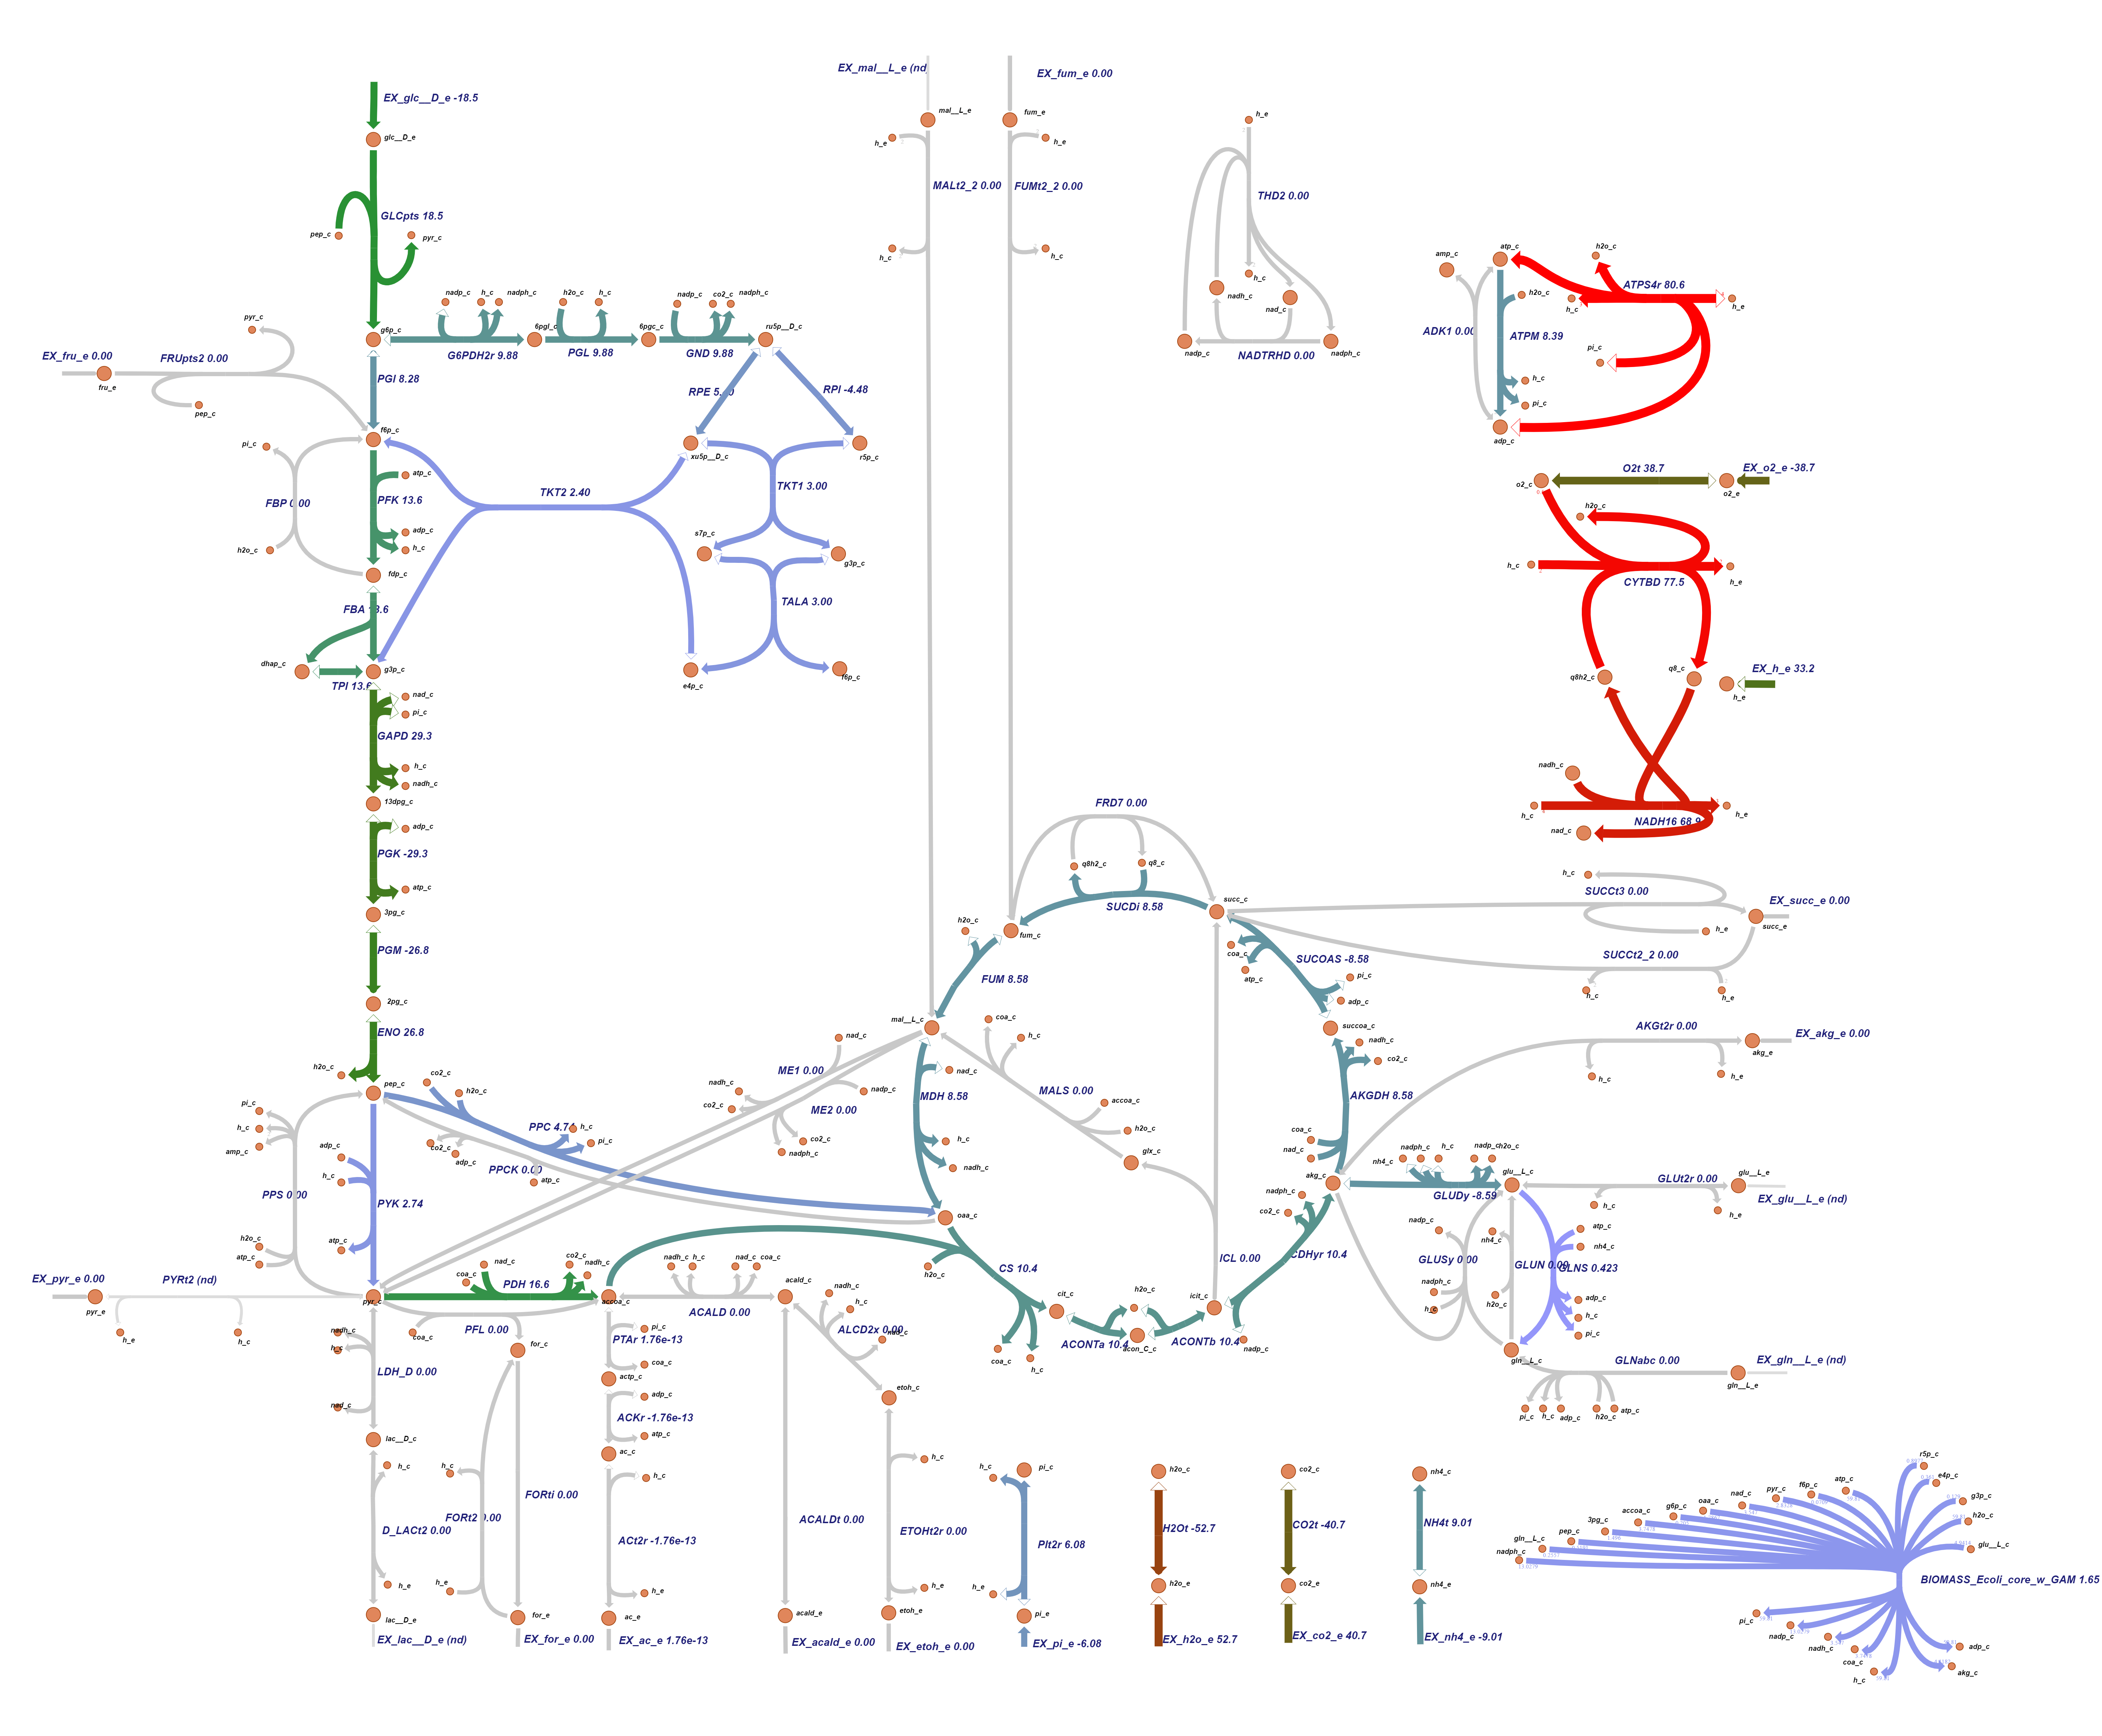

In [48]:
display(Image("aerob_ecoli_model.png"))

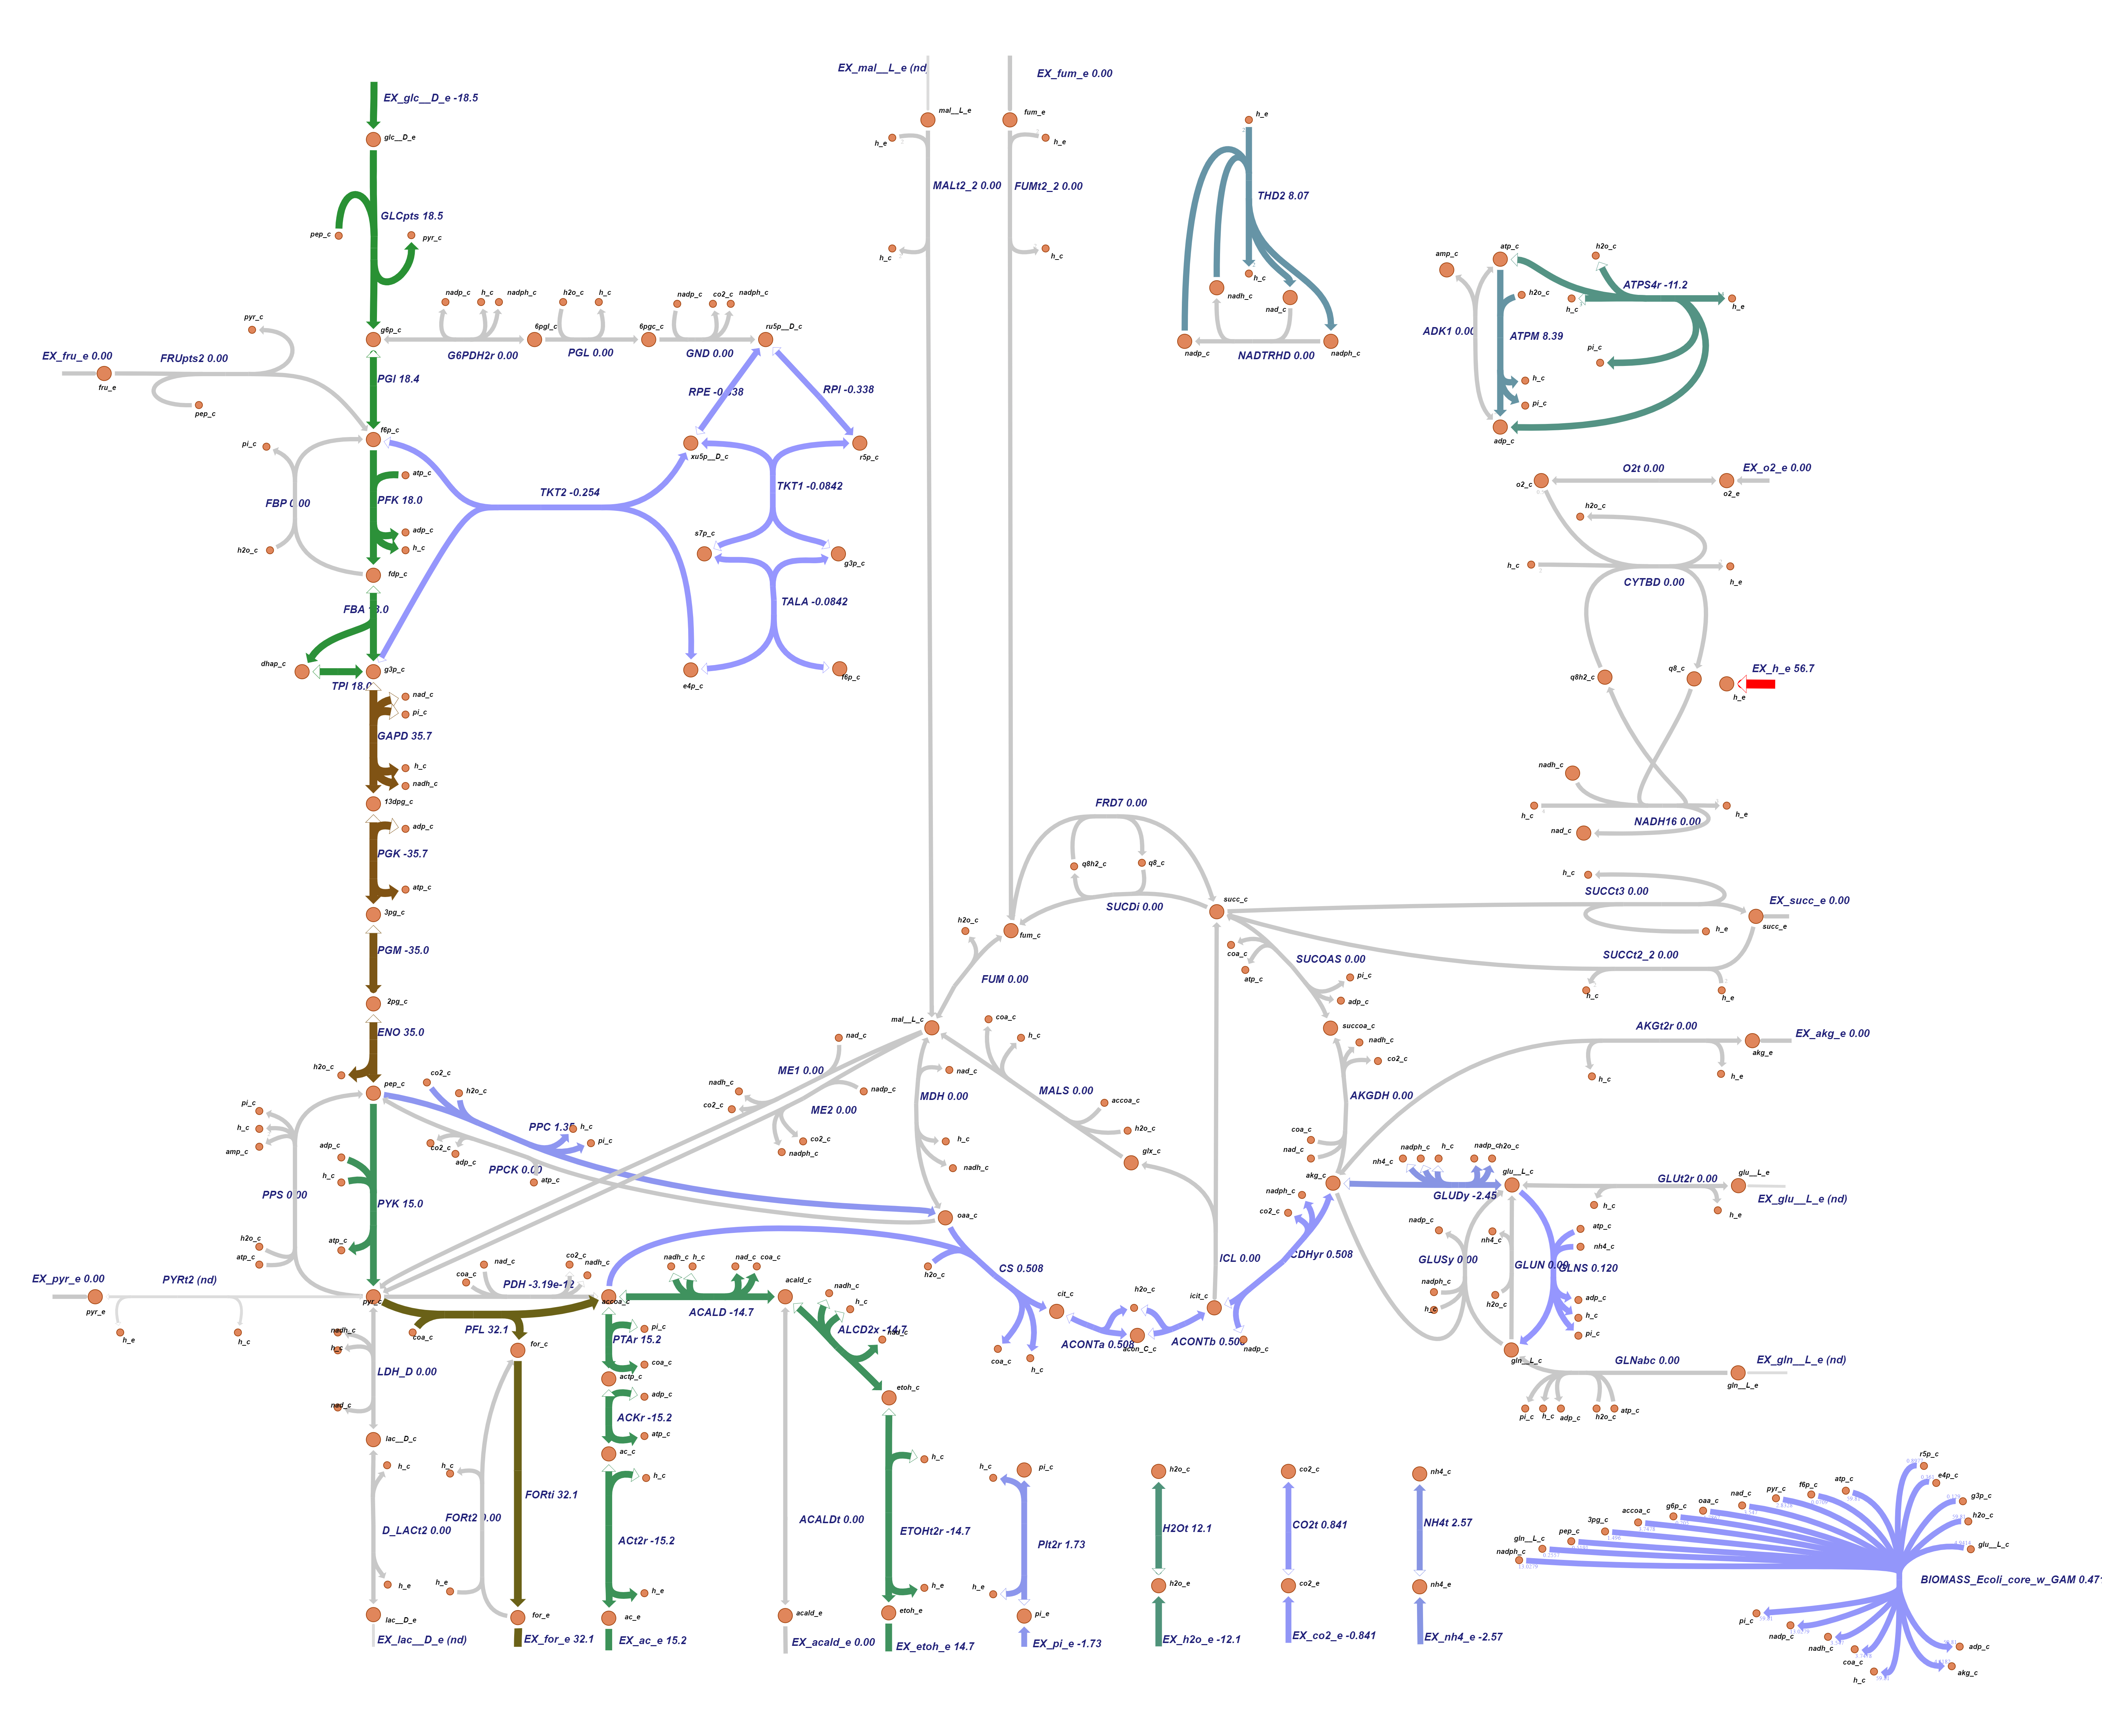

In [49]:
display(Image("anaerob_ecoli_model.png"))

**From the first picture, which is of the aerobic model, one can clearly see that there is a lot of activity (i.e. red color) by the portion of the metabolic pathways that transport $H^+$ over the membrane to create a proton-motive force (chemosmosis), which is then used for ATP synthesis. In the same area of the model $O_2$ is extracted from the environment. Moreover, the entire citric acid cycle seems to be active, and no activity in the fermentation pathways.**

**In comparison, at the last picture, which is of the anaerobic model, the fermentation pathways are active. As mentioned earlier, these pathways synthesis $NAD+$ which under anoxic condition is a limiting factor of ATP synthesis. Portions of the citric acid cycle is still active, leading to some flux in reactions that I believe is important for amino acid synthesis (Glutamine synthetase), that is necessary for growth**

(v) Setting the maximal substrate uptake flux to 10 mmol gDW<sup>-1</sup> h<sup>-1</sup>, maximize growth using each of the carbon sources listed in Table 1 individually under both aerobic and anaerobic conditions.

### Table 1 
| Substrate | Exchange reaction ID |
| --- | --- |
| acetate | EX_ac_e |
| acetaldehyde | EX_acald_e |
| 2-oxoglutarate | EX_akg_e | 
| ethanol | EX_etoh_e |
| D-fructose | EX_fru_e |
| fumarate | EX_fum_e |
| D-glucose | EX_glc__D_e |
| L-glutamine | EX_gln_L_e |
| L-glutamate | EX_glu_L_e |
| D-lactate | EX_lac_D_e |
| L-malate | EX_mal_L_e |
| pyruvate | EX_pyr_e |
| succinate | EX_succ_e |

In [ ]:
# Reset the lower bound for glucose (i.e. glucose uptake):
ecoli_aerob.reactions.get_by_id("EX_glc__D_e").lower_bound = 0
ecoli_anaerob.reactions.get_by_id("EX_glc__D_e").lower_bound = 0

# All the exchange reaction IDs:
reac_lst = ["EX_ac_e", "EX_acald_e", "EX_akg_e", "EX_etoh_e",
            "EX_fru_e","EX_fum_e","EX_glc__D_e","EX_gln_L_e",
            "EX_glu_L_e","EX_lac_D_e","EX_mal_L_e",
            "EX_pyr_e","EX_succ_e"]

# Storage lists:
aerob = []
anaerob = []

for reac_id in reac_lst:
    # Set the uptake
    ecoli_aerob.reactions.get_by_id(reac_id).lower_bound = -20.0
    ecoli_anaerob.reactions.get_by_id(reac_id).lower_bound = -20.0
    # Append result to storage lists:
    aerob.append(ecoli_aerob.optimize().objective_value)
    anaerob.append(ecoli_anaerob.optimize().objective_value)
    # Reset the lower bound for the tested substrate:
    ecoli_aerob.reactions.get_by_id(reac_id).lower_bound = 0
    ecoli_anaerob.reactions.get_by_id(reac_id).lower_bound = 0

# Create a data frame:
# First I want a better name for the substrates (i.e. only the name of the substrate):
subs = [str(ecoli.reactions.get_by_id(i).name).replace(" exchange", "") for i in reac_lst]
# Then create the data frame:
df = pd.DataFrame({"Substrate":subs,
                   "Aerob":aerob,
                   "Anaerob":anaerob})
df = pd.melt(df, id_vars=["Substrate"], value_vars=["Aerob", "Anaerob"],
             value_name="Maximal specific growth rate")

# NB! I get some errors, but do not know why!

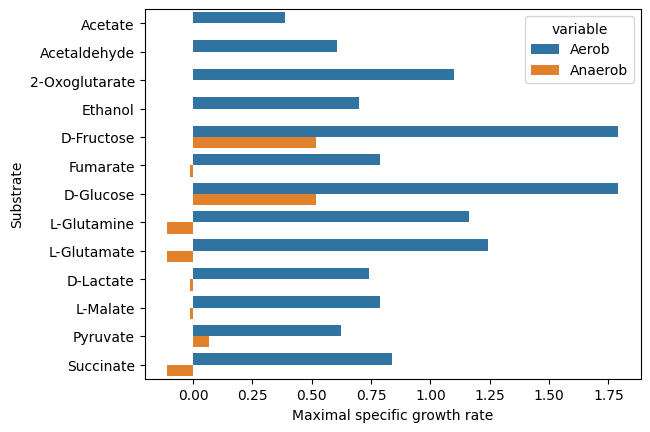

In [51]:
# Display graph:
sns.barplot(data=df, x="Maximal specific growth rate", y="Substrate", hue="variable")
plt.show()